#### Evaluate 5 distinct block-matching algorithms: Fullsearch, 3SS, 4SS, HexBM, and DiamondBM. In each case, the image table is already generated although your solution should work for any size numpy array. The scores in the table represent grayscale image values. 
#### Each evaluation algorithm will use the image table.  Use the score cell as the starting center: (8,8), although this should be programmable or used as default to select the center of an NxN size image array.


In [85]:
import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pprint
import math

#Push physical devices list for GPU 
physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass
    

255
Raw Array
[[178 228  14 164 246 210  82  79  14 157 230 154 145 204  28 178]
 [239 104 202 194  64  21 225 182 255  50 100 215  75 177 118 239]
 [216 155  78 195  38   3 105 101  92 172 179  24  21  43 172 216]
 [110  99 189  54 187  86  29 167  32 140  91 189  10  46 123 110]
 [ 28 172 166 157  34  35  18 118  74 241 119  88 146  92 212  28]
 [ 61  97 165 129 222  93 223  56  57 215 155 242 102 121 249  61]
 [149  69  22 220  77 146  47  68 232 203  16 221 150  65 225 149]
 [135 100 192 110 174 131  41 248 141 124  19 178 180 201  51 135]
 [251 117 102  31  57 161 146 123 244 161  61  51  41  33 158 251]
 [ 47 235 136 252 186  65 145 138 159 228 169 195  66 244  56  47]
 [165  63 194 127  53  79   3  21  85   8 185  41 212 141  38 165]
 [ 20 249 177  38  50 227 156 144  49  41 230 245  49 245 253  20]
 [195 121  21  95 197 243 116 230 235   4  86 204 191 148 150 195]
 [224  26 207  78  12  95 189  67 105  72 212 215 245 249  60 224]
 [  5   8   7  98 233 176 124 251 220 129  82 23

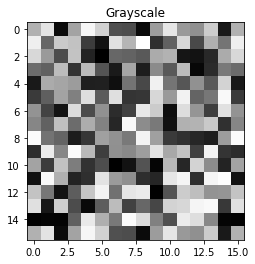

In [86]:
imageTable = np.array([[178,228,14,164,246,210,82,79,14,157,230,154,145,204,28,178],
                       [239,104,202,194,64,21,225,182,255,50,100,215,75,177,118,239],                       
                       [216,155,78,195,38,3,105,101,92,172,179,24,21,43,172,216],                       
                       [110,99,189,54,187,86,29,167,32,140,91,189,10,46,123,110],                       
                       [28,172,166,157,34,35,18,118,74,241,119,88,146,92,212,28],                       
                       [61,97,165,129,222,93,223,56,57,215,155,242,102,121,249,61],                       
                       [149,69,22,220,77,146,47,68,232,203,16,221,150,65,225,149],                      
                       [135,100,192,110,174,131,41,248,141,124,19,178,180,201,51,135],                       
                       [251,117,102,31,57,161,146,123,244,161,61,51,41,33,158,251],                       
                       [47,235,136,252,186,65,145,138,159,228,169,195,66,244,56,47],                       
                       [165,63,194,127,53,79,3,21,85,8,185,41,212,141,38,165],                       
                       [20,249,177,38,50,227,156,144,49,41,230,245,49,245,253,20],                       
                       [195,121,21,95,197,243,116,230,235,4,86,204,191,148,150,195],                       
                       [224,26,207,78,12,95,189,67,105,72,212,215,245,249,60,224],                       
                       [5,8,7,98,233,176,124,251,220,129,82,236,222,137,7,5],                       
                       [178,228,14,164,246,210,82,79,14,157,230,154,145,204,28,178]])

max_image = np.amax(imageTable)
print(max_image)

print("Raw Array")
print(imageTable)
print("\n")
plt.title('Grayscale')
plt.imshow(imageTable, cmap="gray") 
plt.show() 

In [163]:
def get_shapes(roi):
    rows,cols = roi.shape
    s= []
    for x in range (1,15):
        for y in range (1,15):
            s.append(roi[x-1:x+2,y-1:y+2])
            if len(s)<3:
                pass
    return s

def get_scale(image, posistion, size):
    return image[posistion[0]-size:posistion[0]+size+1,posistion[1]-size:posistion[1]+size+1]

def get_min_and_cords(quards,img_partA_ssd):
    send_back = []
    minElement = np.amin(img_partA_ssd)
    minindex = np.argmin(img_partA_ssd)
    send_back.append(minElement)
    send_back.append(quards[minindex])
    return send_back

def calculate_ssd(img1, img2):
    if img1.shape != img2.shape:
        print("Images don't have the same shape.")
        return
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)

def block_to_cross(img):
    img = [[img[0][0],img[0][2],img[0][4]],
           [img[2][0],img[2][2],img[2][4]],
           [img[4][0],img[4][2],img[4][4]]]
    return img

def block_to_hex(img):
    img = [[img[0][1],img[0][3]],
           [img[2][0],img[2][2],img[2][4]],
           [img[4][1],img[4][3]]]
    return img

def block_to_diamond(img):
    img = [[img[0][2]],
           [img[1][1],img[1][3]],
           [img[2][0],img[2][2],img[2][4]],
           [img[3][1],img[3][3]],
           [img[4][2]]]
    return img

mylist = np.indices((15, 15))
x=[x+1 for x in mylist]

new_rois= get_shapes(imageTable)
print(len(new_rois))
#print(new_rois)

196


In [88]:


searchTemplate = np.array([[123, 250,185],[170,24,20], [117,102,31]] )
temp = []
full_scale = []
for i in range (0,len(new_rois)):
    temp= calculate_ssd(new_rois[i], searchTemplate)
    full_scale.append(temp)
#print(full_scale)  # DEBUG

In [166]:
temp = []
quards = []
for i in range(1,len(x[0])):
    for j in range(1,len(x[1])):
        temp.append(i)
        temp.append(j)
        #print(temp)
        quards.append(temp)
        #print(quards)
        
quards= np.array(quards[0]).reshape(-1, 2)

ssd_list = [full_scale[0:14],full_scale[14:28],full_scale[28:42],full_scale[42:56],
            full_scale[56:70],full_scale[70:84],full_scale[84:98],full_scale[98:112],
            full_scale[112:126],full_scale[126:140],full_scale[140:154],full_scale[154:168],
            full_scale[168:182],full_scale[182:196]]

ssd_list_npa = np.asarray(ssd_list, dtype=np.float32)

print(ssd_list_npa)

[[ 91854. 162394.  65077.  15463. 102126. 153780. 147243. 133058.  64285.
   69721.  76699.  56976. 101865. 157341.]
 [ 82724.  44934.  93871.  81862.  87772.  76835.  47236.  73501. 130187.
   78388.  22622.  74880.  80837. 111428.]
 [ 97955.  87127.  61244. 133873.  90395.  92520.  83554.  84975.  73536.
   86227. 128099.  90137. 123817.  59456.]
 [107487.  74368. 100191.  37413. 121919.  94241.  88018. 145132. 127068.
  101210.  84028. 131794. 148403.  91700.]
 [ 55899.  91757. 110218. 140985. 134501. 118118.  92429. 135132.  97964.
  159856. 120777.  56435. 132790. 113518.]
 [ 56372.  75872. 107481.  45702.  64346.  72685. 165221. 157126.  43586.
   90839. 124983.  99368.  79454. 103921.]
 [119813.  97349.  60303. 105601.  64188. 121557. 169218.  71362.  74003.
   93574.  91469.  99246.  95610.  78792.]
 [ 78241.  82453.  77410.  75589. 104038.  89290.  87681. 144216. 106366.
   99528.  41654.  75549.  82762. 156772.]
 [144462. 136845. 152520.  86087.  36769.  67039.  75554.  73159

######  Full Search - Use the center of in each round to find the best value in a 7x7 area surrounding query point. Code Full Search as a BxB location (assume it can be centered by B being odd valued).

In [143]:
img_partA = get_scale(ssd_list_npa, posistion=(8,8), size = 3)
partA_min=get_min_and_cords(quards,img_partA)
print("Full Search Search Stage 2")
print("The array we are calculating:")
print(img_partA)
print("With min positions at:")
print(partA_min)

Full Search Search Stage 2
The array we are calculating:
[[ 72685. 165221. 157126.  43586.  90839. 124983.  99368.]
 [121557. 169218.  71362.  74003.  93574.  91469.  99246.]
 [ 89290.  87681. 144216. 106366.  99528.  41654.  75549.]
 [ 67039.  75554.  73159. 135452. 129005. 136645. 154510.]
 [ 53106.  49436.  40059.  84688. 138248.  90222. 174136.]
 [181563. 150279. 101887. 145591. 190842. 138501.  96158.]
 [ 88575. 134283. 114145.  93968. 123961. 166257. 181891.]]
With min positions at:
[40059.0, array([3, 3])]


######  3SS (3 Stage Search) - Use the center of in each round to find the best value.

In [147]:
img_partB_ssd1 = get_scale(ssd_list_npa,  posistion=(8,8), size = 3)    
img_partB1 = block_to_cross(img_partB_ssd1)
partB_min1 = get_min_and_cords(quards,img_partB1)
print("3SS Search Stage 1")
print("The array we are calculating:")
print(img_partB1)
print("With min positions at:")
print(partB_min1)


3SS Search Stage 1
The array we are calculating:
[[72685.0, 157126.0, 90839.0], [89290.0, 144216.0, 99528.0], [53106.0, 40059.0, 138248.0]]
With min positions at:
[40059.0, array([1, 8])]


In [148]:
img_partB_ssd2 = get_scale(ssd_list_npa,  posistion=(5,8), size = 2)
img_partB2 = block_to_cross(img_partB_ssd2)
partB_min2 = get_min_and_cords(quards,img_partB2)
print("3SS Search Stage 2")
print("The array we are calculating:")
print(img_partB2)
print("With min positions at:")
print(partB_min2)


3SS Search Stage 2
The array we are calculating:
[[88018.0, 127068.0, 84028.0], [165221.0, 43586.0, 124983.0], [87681.0, 106366.0, 41654.0]]
With min positions at:
[41654.0, array([1, 9])]


In [149]:
img_partB_ssd3 =get_scale(ssd_list_npa, posistion=(7,10), size = 1)
partB_min3 = get_min_and_cords(quards,img_partB_ssd3)
print("3SS Search Stage 3")
print("The array we are calculating:")
print(img_partB_ssd3)
print("With min positions at:")
print(partB_min3)

3SS Search Stage 3
The array we are calculating:
[[ 93574.  91469.  99246.]
 [ 99528.  41654.  75549.]
 [129005. 136645. 154510.]]
With min positions at:
[41654.0, array([1, 5])]


###### 4SS (4 Stage Search) - Use the center of in each round to find the best value.

In [150]:
img_partC_ssd1 =get_scale(ssd_list_npa, posistion=(8,8), size = 2)
img_partC1 = block_to_cross(img_partC_ssd1)
partC_min1 = get_min_and_cords(quards,img_partC1 )
print("4SS Search Stage 1")
print("The array we are calculating:")
print(img_partC1)
print("With min positions at:")
print(partC_min1)

4SS Search Stage 1
The array we are calculating:
[[169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0], [150279.0, 145591.0, 138501.0]]
With min positions at:
[74003.0, array([1, 2])]


In [151]:
img_partC_ssd2 =get_scale(ssd_list_npa, posistion=(6,8), size = 2)
img_partC2 = block_to_cross(img_partC_ssd2)
partC_min2 = get_min_and_cords(quards,img_partC2)
print("4SS Search Stage 2")
print("The array we are calculating:")
print(img_partC2)
print("With min positions at:")
print(partC_min2)

4SS Search Stage 2
The array we are calculating:
[[92429.0, 97964.0, 120777.0], [169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0]]
With min positions at:
[74003.0, array([1, 5])]


In [152]:
img_partC_ssd3 =get_scale(ssd_list_npa, posistion=(6,8), size = 2)
img_partC3 = block_to_cross(img_partC_ssd3)
partC_min3 = get_min_and_cords(quards,img_partC3)
print("4SS Search Stage 3")
print("The array we are calculating:")
print(img_partC3)
print("With min positions at:")
print(partC_min3)

4SS Search Stage 3
The array we are calculating:
[[92429.0, 97964.0, 120777.0], [169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0]]
With min positions at:
[74003.0, array([1, 5])]


In [153]:
img_partC_ssd4 =get_scale(ssd_list_npa, posistion=(6,8), size = 1)
partC_min4 = get_min_and_cords(quards,img_partC_ssd4)
print("4SS Search Stage 4")
print("The array we are calculating:")
print(img_partC_ssd4)
print("With min positions at:")
print(partC_min4)

4SS Search Stage 4
The array we are calculating:
[[157126.  43586.  90839.]
 [ 71362.  74003.  93574.]
 [144216. 106366.  99528.]]
With min positions at:
[43586.0, array([1, 2])]


######  HexagonBM- Use the center of in each round to find the best value.

In [154]:
img_partD_ssd1 =get_scale(ssd_list_npa, posistion=(8,8), size = 2)
img_partD1 = block_to_cross(img_partD_ssd1)
partD_min1 = get_min_and_cords(quards,img_partB2 )
print("HexagonBM Search Stage 1")
print("The array we are calculating:")
print(img_partD1)
print("With min positions at:")
print(partD_min1)



HexagonBM Search Stage 1
The array we are calculating:
[[169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0], [150279.0, 145591.0, 138501.0]]
With min positions at:
[41654.0, array([1, 9])]


In [155]:
img_partD_ssd2 =get_scale(ssd_list_npa, posistion=(6,8), size = 2)
img_partD2 = block_to_cross(img_partD_ssd2)
partD_min2 = get_min_and_cords(quards,img_partD2)
print("HexagonBM Search Stage 2")
print("The array we are calculating:")
print(img_partD2)
print("With min positions at:")
print(partD_min2)


HexagonBM Search Stage 2
The array we are calculating:
[[92429.0, 97964.0, 120777.0], [169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0]]
With min positions at:
[74003.0, array([1, 5])]


In [156]:
img_partD_ssd3 =get_scale(ssd_list_npa, posistion=(6,8), size = 2)
img_partD3 = block_to_cross(img_partD_ssd3)
partD_min3 = get_min_and_cords(quards,img_partD3)
print("HexagonBM Search Stage 3")
print("The array we are calculating:")
print(img_partD3)
print("With min positions at:")
print(partC_min3)


HexagonBM Search Stage 3
The array we are calculating:
[[92429.0, 97964.0, 120777.0], [169218.0, 74003.0, 91469.0], [75554.0, 135452.0, 136645.0]]
With min positions at:
[74003.0, array([1, 5])]


In [157]:
img_partD_ssd4 =get_scale(ssd_list_npa, posistion=(6,8), size = 1)
partD_min4 = get_min_and_cords(quards,img_partD_ssd4)
print("HexagonBM Search Stage 4")
print("The array we are calculating:")
print(img_partD_ssd4)
print("With min positions at:")
print(partD_min4)

HexagonBM Search Stage 4
The array we are calculating:
[[157126.  43586.  90839.]
 [ 71362.  74003.  93574.]
 [144216. 106366.  99528.]]
With min positions at:
[43586.0, array([1, 2])]


###### Diamond- Use the center of in each round to find the best value.

In [158]:
img_partE_ssd1 =get_scale(ssd_list_npa, posistion=(8,8), size = 2)
img_partE1 =  block_to_diamond(img_partE_ssd1)
partE_min1 = get_min_and_cords(quards,img_partE1)
print("Diamond Search Stage 1")
print("The array we are calculating:")
print(img_partE1)
print("With min positions at:")
print(partE_min1)

Diamond Search Stage 1
The array we are calculating:
[[74003.0], [144216.0, 99528.0], [75554.0, 135452.0, 136645.0], [40059.0, 138248.0], [145591.0]]
With min positions at:
[[40059.0, 138248.0], array([1, 4])]


In [159]:
img_partE_ssd2 =get_scale(ssd_list_npa, posistion=(9,7), size = 2)
img_partE2 =  block_to_diamond(img_partE_ssd2)
partE_min2 = get_min_and_cords(quards,img_partE2)
print("Diamond Search Stage 2")
print("The array we are calculating:")
print(img_partE2)
print("With min positions at:")
print(partE_min2)

Diamond Search Stage 2
The array we are calculating:
[[144216.0], [75554.0, 135452.0], [53106.0, 40059.0, 138248.0], [150279.0, 145591.0], [114145.0]]
With min positions at:
[[53106.0, 40059.0, 138248.0], array([1, 3])]


In [160]:
img_partE_ssd3 =get_scale(ssd_list_npa, posistion=(9,7), size = 2)
img_partE3 = block_to_diamond(img_partE_ssd3)
partE_min3 = get_min_and_cords(quards,img_partE3)
print("Diamond Search Stage 3")
print("The array we are calculating:")
print(img_partE3)
print("With min positions at:")
print(partE_min3)

Diamond Search Stage 3
The array we are calculating:
[[144216.0], [75554.0, 135452.0], [53106.0, 40059.0, 138248.0], [150279.0, 145591.0], [114145.0]]
With min positions at:
[[53106.0, 40059.0, 138248.0], array([1, 3])]


In [161]:
img_partE_ssd4 =get_scale(ssd_list_npa, posistion=(9,7), size = 1)
img_partE4 = [[img_partE_ssd4[0][1]],[img_partE_ssd4[1][0],img_partE_ssd4[1][1],img_partE_ssd4[1][2]],[img_partE_ssd4[2][1]]]
partE_min4 = get_min_and_cords(quards,img_partE4)
print("Diamond Search Stage 4")
print("The array we are calculating:")
print(img_partE4)
print("With min positions at:")
print(partE_min4)


Diamond Search Stage 4
The array we are calculating:
[[73159.0], [49436.0, 40059.0, 84688.0], [101887.0]]
With min positions at:
[[49436.0, 40059.0, 84688.0], array([1, 2])]


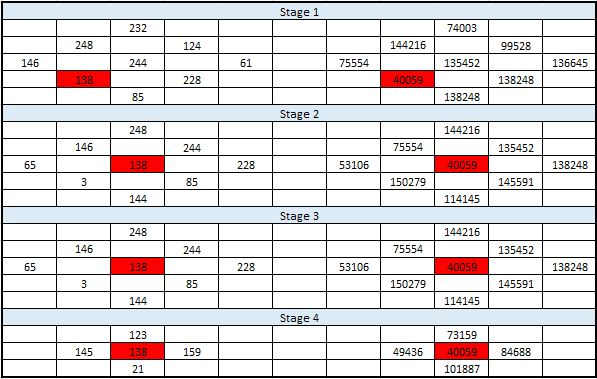

######  Block Match Scoring: For each stage, generate the positions of the ImageTable with the highest candidate score and the score

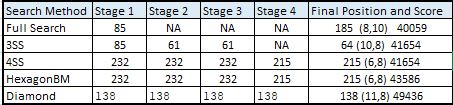